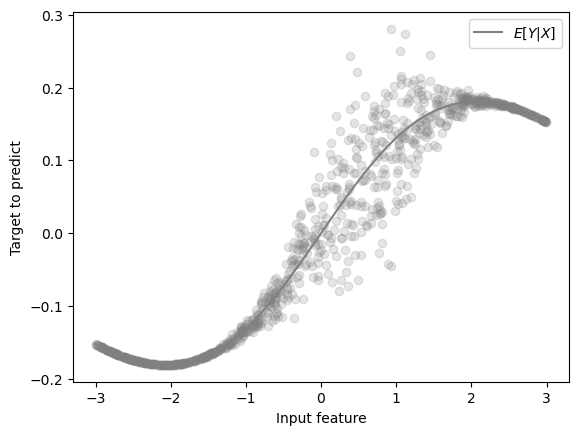

In [1]:
import numpy as np
from scipy.special import expit
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

rng = np.random.default_rng(0)
n_samples = int(2e4)
x = rng.uniform(low=-3, high=3, size=n_samples)
X = x.reshape((n_samples, 1))


def true_y_mean(x):
    return expit(x) - 0.5 - 0.1 * x


def true_y_std(x):
    return 0.07 * np.exp(-((x - 0.5) ** 2) / 0.9)


y = rng.normal(loc=true_y_mean(x), scale=true_y_std(x))
X_train, X_test, x_train, x_test, y_train, y_test = train_test_split(
    X, x, y, test_size=0.5, random_state=0
)


def plot_data_generating_process(
    x,
    y,
    plot_data=True,
    max_scatter_points=1_000,
    plot_mean=True,
    plot_005_quantile=True,
    plot_095_quantile=True,
    color="gray",
    highlight_indices=None,
    ax=None,
):
    x_grid = np.linspace(x.min(), x.max(), 100)
    if ax is None:
        _, ax = plt.subplots(constrained_layout=True)
    if plot_data:
        ax.scatter(
            x=x[:max_scatter_points],
            y=y[:max_scatter_points],
            alpha=0.2,
            color=color,
        )

    if plot_mean:
        ax.plot(x_grid, true_y_mean(x_grid), label="$E[Y|X]$", color=color)
    if plot_095_quantile:
        ax.plot(
            x_grid,
            true_y_mean(x_grid) + 1.645 * true_y_std(x_grid),
            linestyle="--",
            color=color,
        )
    if plot_005_quantile:
        ax.plot(
            x_grid,
            true_y_mean(x_grid) - 1.645 * true_y_std(x_grid),
            linestyle="--",
            label=r"$Q[Y|X]$",
            color=color,
        )
    if plot_data and highlight_indices:
        for i, idx in enumerate(highlight_indices):
            ax.scatter(
                x=[x[idx]], y=[y[idx]], alpha=1, marker="^", s=100, color=f"C{i}"
            )
    if plot_mean or plot_005_quantile:
        ax.legend()

fig, ax = plt.subplots()
ax.set(xlabel="Input feature", ylabel="Target to predict")
plot_data_generating_process(
    x_train, y_train, ax=ax,
    plot_005_quantile=False,
    plot_095_quantile=False
)

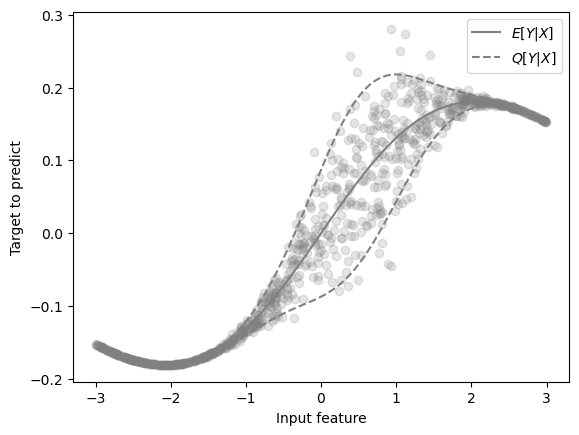

In [2]:
fig, ax = plt.subplots()
ax.set(xlabel="Input feature", ylabel="Target to predict")
plot_data_generating_process(
    x_train, y_train, ax=ax, plot_005_quantile=True, plot_095_quantile=True
)

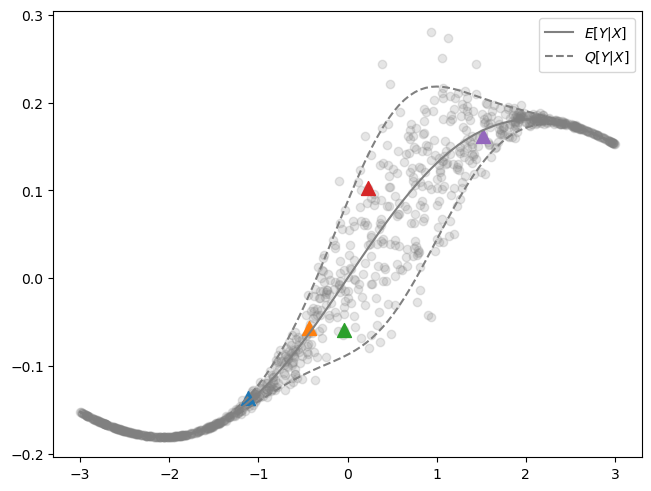

In [3]:
import pandas as pd

df_train = pd.DataFrame(
    {"x": x_train, "y": y_train, "y_diff": y_train - true_y_mean(x_train)}
)[:1000]
df_train["x_bin"] = pd.qcut(df_train["x"], q=5, labels=range(5))
highlight_indices = []

for x_bin in [1, 2, 3]:
    region = df_train.query("x_bin == @x_bin", engine='python').copy()
    region["y_diff_bin"] = pd.qcut(region["y_diff"], q=20, labels=range(20))
    if x_bin in [1, 3]:
        trimmed_region = region.query(
            "y_diff_bin > 0 & y_diff_bin < 18", engine="python"
        )
        highlight_indices.extend(trimmed_region.sample(n=1, random_state=0).index)
    if x_bin == 2:
        highlight_indices.extend(
            region.query("y_diff_bin == 1", engine="python")
            .sample(n=1, random_state=0)
            .index
        )
        highlight_indices.extend(
            region.query("y_diff_bin == 10", engine="python")
            .sample(n=1, random_state=0)
            .index
        )
        highlight_indices.extend(
            region.query("y_diff_bin == 18", engine="python")
            .sample(n=1, random_state=0)
            .index
        )

highlight_indices = df_train.iloc[highlight_indices].sort_values(by="x").index.tolist()
plot_data_generating_process(x_train, y_train, highlight_indices=highlight_indices)

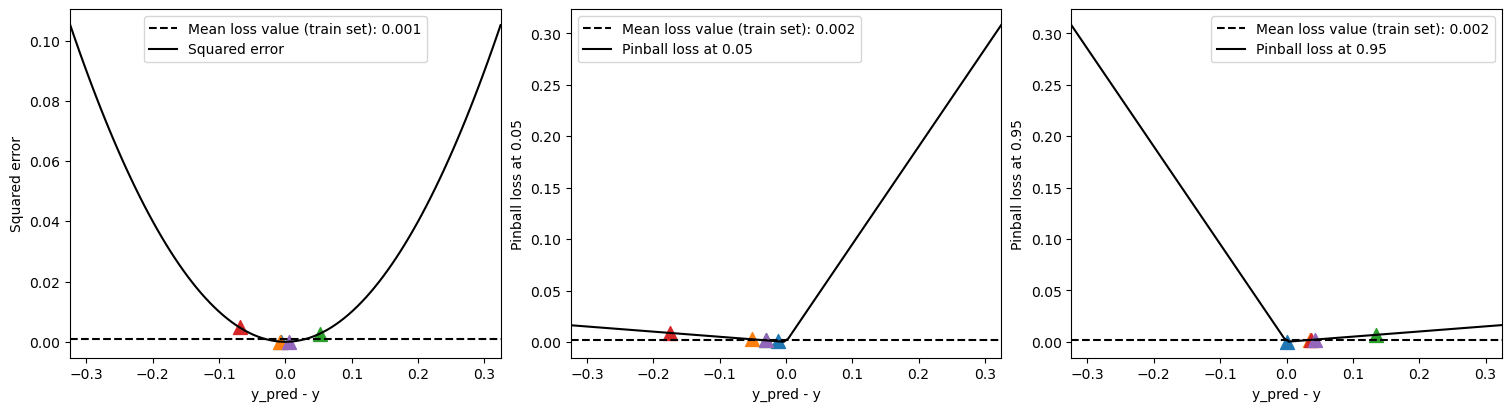

In [4]:
from sklearn.metrics import mean_squared_error, mean_pinball_loss
from functools import partial


def make_loss_function(loss_name, quantile=0.5, return_label=True):
    if loss_name == "squared_error":
        if return_label:
            return mean_squared_error, "MSE loss"
        else:
            return mean_squared_error
    elif loss_name == "quantile":
        if return_label:
            return (
                partial(mean_pinball_loss, alpha=quantile),
                f"Pinball loss (q={quantile:.2f})",
            )
        else:
            return partial(mean_pinball_loss, alpha=quantile)
    else:
        raise ValueError(f"Unsupported loss {loss_name:!r}")


def plot_loss_function(
    loss_fun,
    loss_label,
    y_true,
    y_pred,
    highlight_indices=None,
    diff_grid_range=None,
    data_name="train",
    mean_loss=True,
    legend=True,
    ax=None,
):
    if ax is None:
        _, ax = plt.subplots(constrained_layout=True)

    if diff_grid_range is None:
        # Maximum absolute diff observed for a 0 prediction (e.g. a linear
        # model init).
        max_abs = np.abs(y_true).max()
        diff_grid_range = (-max_abs, max_abs)

    if mean_loss:
        mean_loss_value = loss_fun(y_true, y_pred)
        ax.hlines(
            mean_loss_value,
            diff_grid_range[0],
            diff_grid_range[1],
            label=f"Mean loss value ({data_name} set): {mean_loss_value:.3f}",
            linestyle="--",
            color="black",
        )
    n_steps = 100
    y_pred_grid = np.linspace(diff_grid_range[0], diff_grid_range[1], n_steps)
    ax.plot(
        y_pred_grid,
        [loss_fun([0], [y_pred_grid_i]) for y_pred_grid_i in y_pred_grid],
        color="black",
        label=loss_label,
    )
    if highlight_indices:
        for i, idx in enumerate(highlight_indices):
            loss_value = loss_fun([y_true[idx]], [y_pred[idx]])
            ax.scatter(
                y_pred[idx] - y_true[idx],
                loss_value,
                color=f"C{i}",
                s=100,
                marker="^",
            )
    ax.set(xlim=diff_grid_range, xlabel="y_pred - y", ylabel=loss_label)
    if legend:
        ax.legend()


fig, axs = plt.subplots(ncols=3, figsize=(15, 4), constrained_layout=True)

plot_loss_function(
    mean_squared_error,
    "Squared error",
    y_train,
    true_y_mean(x_train),
    highlight_indices=highlight_indices,
    ax=axs[0],
)
plot_loss_function(
    partial(mean_pinball_loss, alpha=0.05),
    "Pinball loss at 0.05",
    y_train,
    true_y_mean(x_train) - 1.645 * true_y_std(x_train),
    highlight_indices=highlight_indices,
    ax=axs[1],
)
plot_loss_function(
    partial(mean_pinball_loss, alpha=0.95),
    "Pinball loss at 0.95",
    y_train,
    true_y_mean(x_train) + 1.645 * true_y_std(x_train),
    highlight_indices=highlight_indices,
    ax=axs[2],
)

In [5]:
from sklearn.base import RegressorMixin
from sklearn.linear_model._base import LinearModel
from scipy.optimize import minimize
import warnings
from sklearn.exceptions import ConvergenceWarning


def pinball_loss_gradient(X, y, coef, intercept, quantile):
    y_pred = X @ coef + intercept
    error = y - y_pred
    mask = (error >= 0).astype(X.dtype)
    weights = -quantile * mask + (1 - quantile) * (1 - mask)
    grad_coef = weights @ X / len(y)
    grad_intercept = weights.mean()
    return grad_coef, grad_intercept


class NaiveRegressor(RegressorMixin, LinearModel):

    def __init__(
        self,
        loss="squared_error",
        quantile=0.5,
        alpha=0,
        l1_ratio=0.1,
        tol=1e-6,
        max_iter=10_000,
        verbose=False,
    ):
        self.loss = loss
        self.quantile = quantile
        self.max_iter = max_iter
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.tol = tol
        self.verbose = verbose

    def fit(self, X, y):
        params = np.zeros(X.shape[1] + 1)
        n_iter_holder = np.zeros(1, dtype=np.int32)

        loss_fun = make_loss_function(
            self.loss, quantile=self.quantile, return_label=False
        )

        def objective(params):
            return (
                loss_fun(y, X @ params[:-1] + params[-1])
                + self.l1_ratio * self.alpha * np.linalg.norm(params[:-1], 1)
                + (1 - self.l1_ratio) * self.alpha * np.linalg.norm(params[:-1], 2) ** 2
            )

        def iter_cb(params):
            n_iter_holder[0] += 1
            n_iter = n_iter_holder[0]
            if self.verbose and n_iter % 10 == 0:
                loss = loss_fun(y, X @ params[:-1] + params[-1])
                print(f"{self.loss} at iteration {n_iter}: {loss:.6f}")
            if n_iter_holder[0] >= self.max_iter:
                raise StopIteration()

        if self.max_iter > 0:
            result = minimize(objective, params, tol=self.tol, callback=iter_cb)
            params = result.x
        self.coef_ = params[:-1]
        self.intercept_ = params[-1]
        self.n_iter_ = n_iter_holder[0]
        if self.n_iter_ == self.max_iter:
            warnings.warn(
                f"Fail to converge after reaching {self.max_iter} iterations",
                ConvergenceWarning,
            )
        return self

    def predict(self, X):
        return X @ self.coef_ + self.intercept_

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import SplineTransformer

n_knots = 10

shared_params = dict(
    tol=1e-4,
    alpha=1e-6,
    l1_ratio=0.1,
)
poly_reg_record = []
poly_reg_max_iters = [0, 2, 5, 10, 50, 100]

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    for max_iter in poly_reg_max_iters:
        shared_params["max_iter"] = max_iter
        poly_reg_triplet = (
            make_pipeline(
                SplineTransformer(n_knots=n_knots), NaiveRegressor(**shared_params)
            ).fit(X_train, y_train),
            make_pipeline(
                SplineTransformer(n_knots=n_knots),
                NaiveRegressor(loss="quantile", quantile=0.05, **shared_params),
            ).fit(X_train, y_train),
            make_pipeline(
                SplineTransformer(n_knots=n_knots),
                NaiveRegressor(loss="quantile", quantile=0.95, **shared_params),
            ).fit(X_train, y_train),
        )
        print(
            tuple(int(getattr(e.steps[-1][1], "n_iter_", 1)) for e in poly_reg_triplet)
        )
        poly_reg_record.append(dict(
            max_iter=max_iter,
            model_triplet=poly_reg_triplet,
        ))

(0, 0, 0)
(2, 2, 2)
(5, 5, 5)
(10, 10, 10)
(29, 50, 50)
(29, 81, 100)


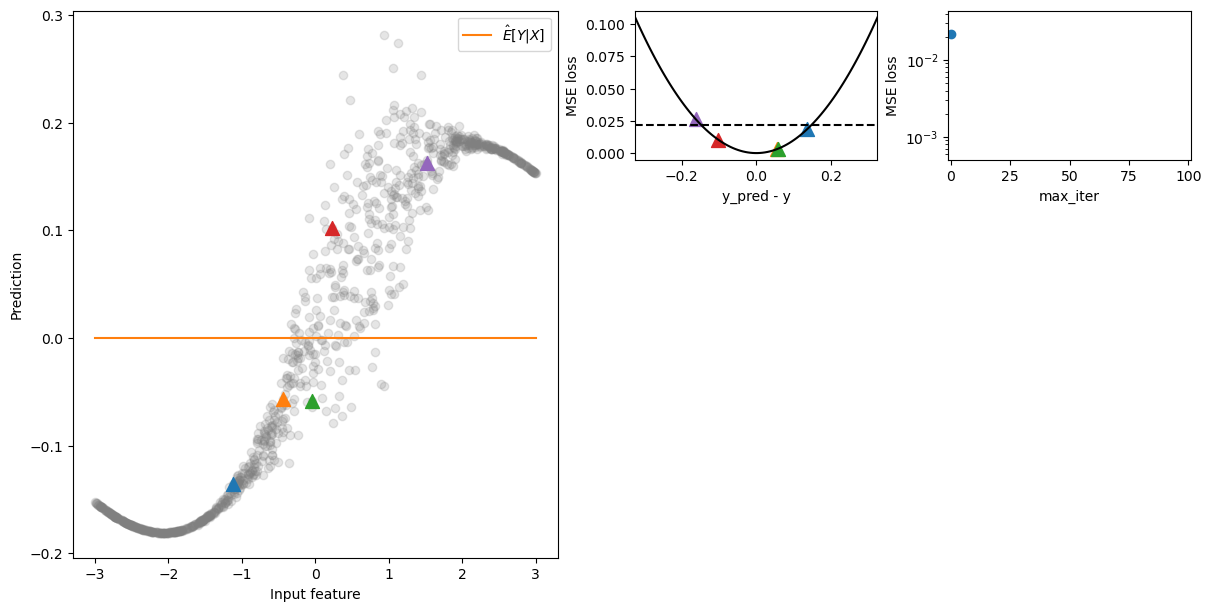

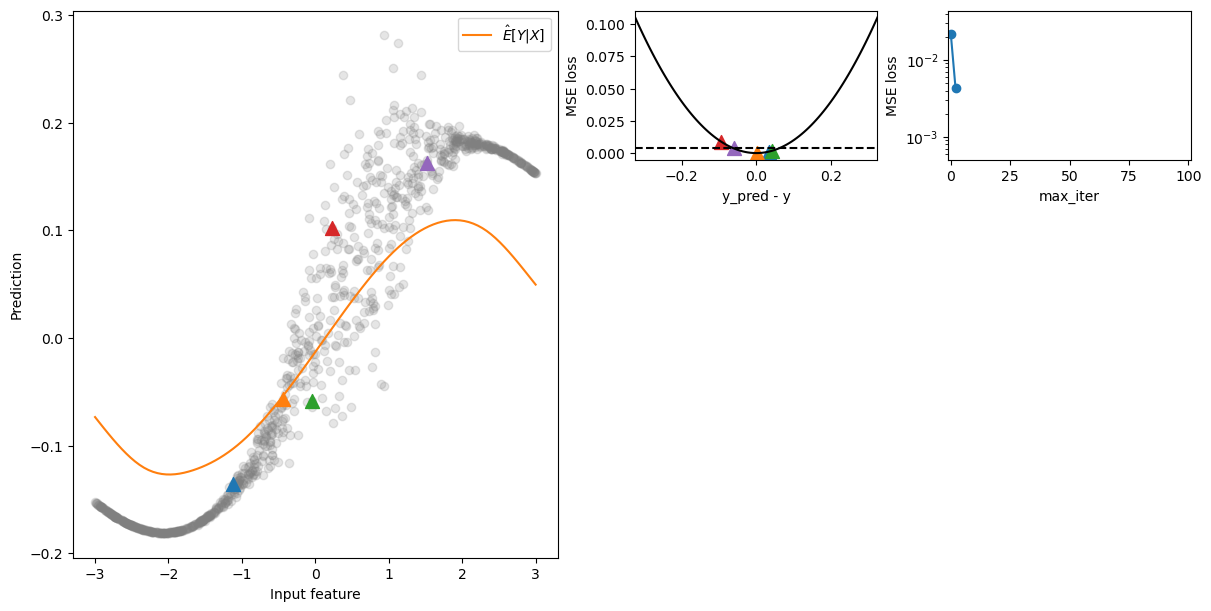

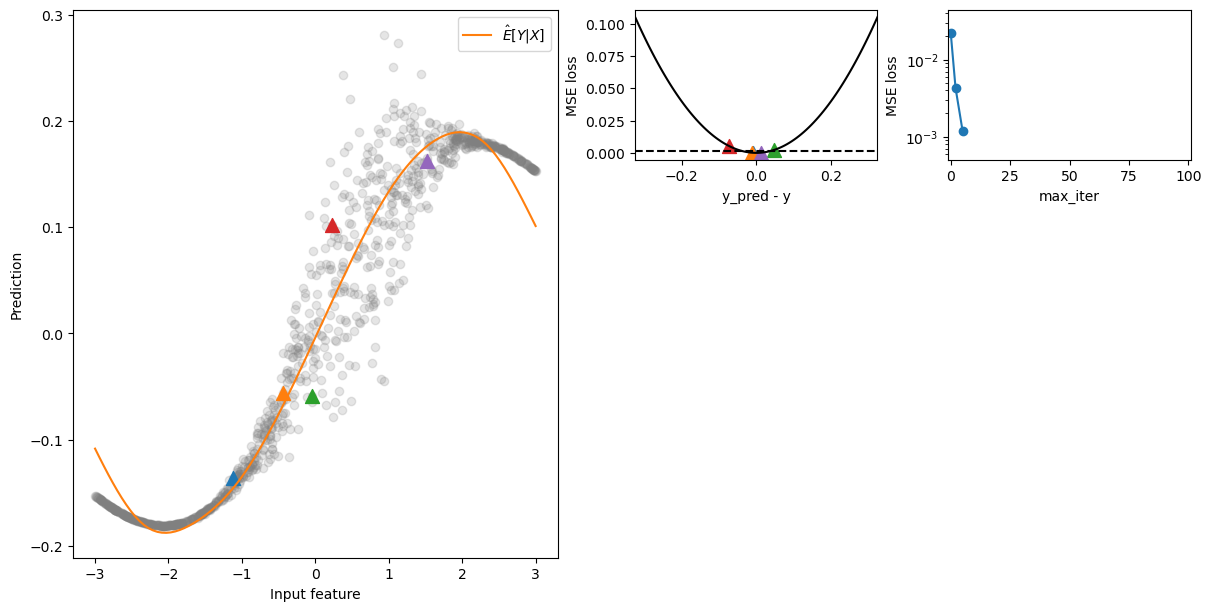

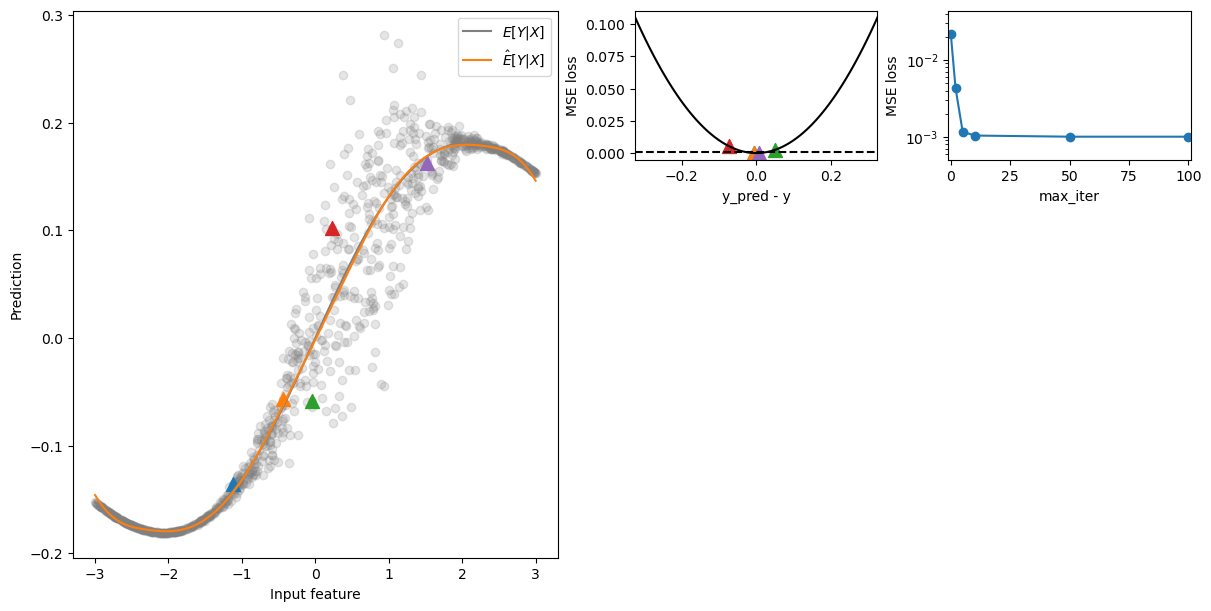

In [7]:
def loss_from_model(model):
    if hasattr(model, "steps"):
        model = model.steps[-1][1]
    return make_loss_function(model.loss, quantile=model.quantile)


def plot_model_triplet(models, x, ax=None, color="C1", show_quantiles=True):
    x_grid = np.linspace(x.min(), x.max(), 100)
    X_grid = x_grid.reshape((x_grid.shape[0], 1))
    if ax is None:
        _, ax = plt.subplots(constrained_layout=True)

    ax.plot(x_grid, models[0].predict(X_grid), label=r"$\hat{E}[Y|X]$", color=color)
    if show_quantiles:
        ax.plot(
            x_grid,
            models[1].predict(X_grid),
            linestyle="--",
            color=color,
        )
        ax.plot(
            x_grid,
            models[2].predict(X_grid),
            linestyle="--",
            label=r"$\hat{Q}[Y|X]$",
            color=color,
        )
    ax.set(
        xlabel="Input feature",
        ylabel="Prediction",
    )
    ax.legend()


def plot_loss_curve(max_iters, models, X, y, display_step, ax=None):
    if ax is None:
        _, ax = plt.subplots(constrained_layout=True)
    loss_fun, loss_label = loss_from_model(models[0])
    max_iters = np.asarray(max_iters)
    loss_values = np.asarray([loss_fun(y, m.predict(X)) for m in models])

    ax.plot(max_iters[: display_step + 1], loss_values[: display_step + 1], marker="o")
    ax.set(
        xlabel="max_iter",
        ylabel=loss_label,
        yscale="log",
        xlim=(max_iters.min() - 1, max_iters.max() + 1),
        ylim=(loss_values.min() * 0.5, loss_values.max() * 2),
    )


def plot_curves(record, model_name, show_quantiles=True):
    for display_step in [0, 1, 2, len(record) - 1]:

        truncated_record = record[: display_step + 1]
        fig = plt.figure(figsize=(12, 6), layout="constrained")
        ax0 = plt.subplot2grid((3, 4), (0, 0), rowspan=3, colspan=2)
        ax1 = plt.subplot2grid((3, 4), (0, 2))
        if show_quantiles:
            ax2 = plt.subplot2grid((3, 4), (1, 2))
            ax3 = plt.subplot2grid((3, 4), (2, 2))
        else:
            ax2, ax3 = None, None

        ax4 = plt.subplot2grid((3, 4), (0, 3))
        if show_quantiles:
            ax5 = plt.subplot2grid((3, 4), (1, 3))
            ax6 = plt.subplot2grid((3, 4), (2, 3))
        else:
            ax5, ax6 = None, None

        is_last_in_record = display_step == len(record) - 1
        plot_data_generating_process(
            x_train,
            y_train,
            highlight_indices=highlight_indices,
            plot_mean=is_last_in_record,
            plot_005_quantile=show_quantiles and is_last_in_record,
            plot_095_quantile=show_quantiles and is_last_in_record,
            ax=ax0,
        )
        plot_model_triplet(
            truncated_record[-1]["model_triplet"],
            x_train,
            show_quantiles=show_quantiles,
            ax=ax0,
        )
        for model_idx, (ax_loss_fun, ax_loss_curve) in enumerate(
            [(ax1, ax4), (ax2, ax5), (ax3, ax6)],
        ):
            last_model = truncated_record[-1]["model_triplet"][model_idx]
            loss_fun, loss_label = loss_from_model(last_model)
            if loss_fun is not mean_squared_error and not show_quantiles:
                continue

            plot_loss_function(
                loss_fun,
                loss_label,
                y_train,
                last_model.predict(X_train),
                highlight_indices=highlight_indices,
                legend=False,
                ax=ax_loss_fun,
            )

            plot_loss_curve(
                [r["max_iter"] for r in poly_reg_record],
                [r["model_triplet"][model_idx] for r in poly_reg_record],
                X_train,
                y_train,
                display_step,
                ax=ax_loss_curve,
            )
        if show_quantiles:
            with_or_without = "with"
        else:
            with_or_without = "without"
        fig.savefig(
            f"probabilistic_regression_curves_step"
            f"_{model_name.lower().replace(" ", "_")}"
            f"_{with_or_without}_quantiles"
            f"_{display_step:02d}.png"
        )


plot_curves(poly_reg_record, "Polynomial Regressor", show_quantiles=False)

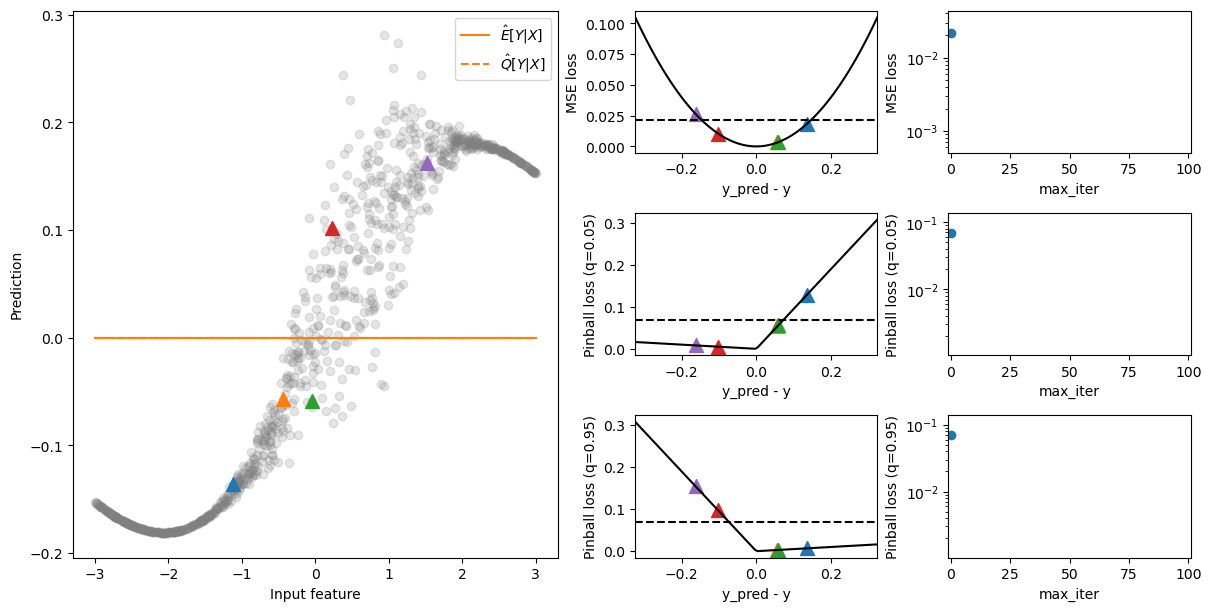

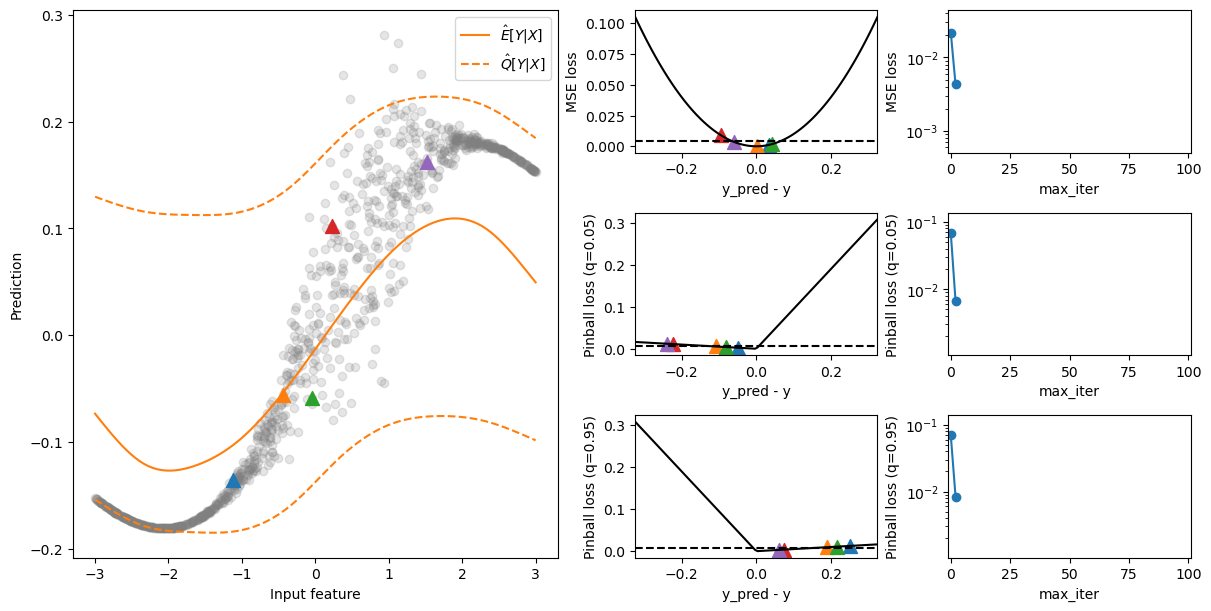

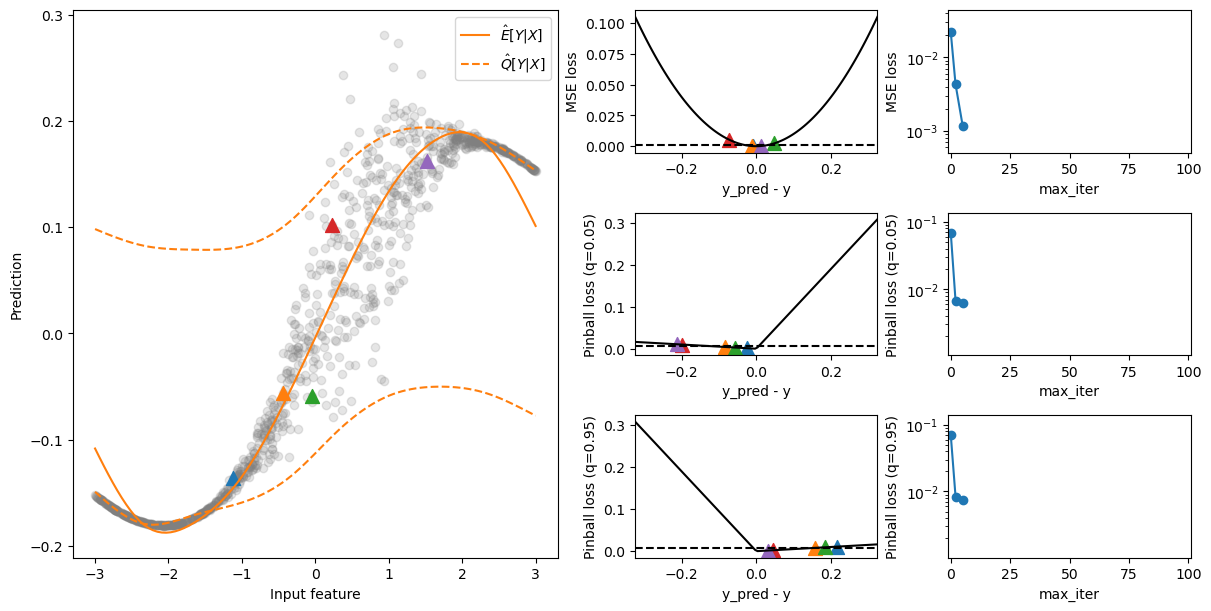

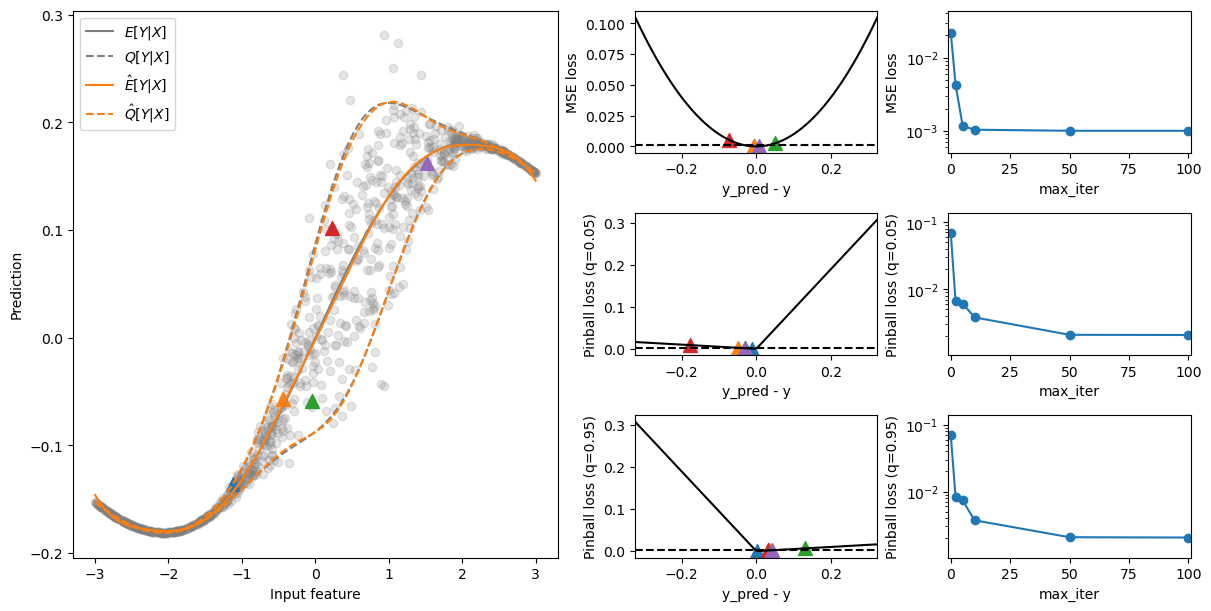

In [8]:
plot_curves(poly_reg_record, "Polynomial Regressor", show_quantiles=True)

In [9]:
class QuantilePairEvaluator:

    def __init__(self, y, data_name, quantile_levels=(0.05, 0.95)):
        self.quantile_level_low, self.quantile_level_high = quantile_levels
        self.data_name = data_name
        self.y = y
        self.records = []

    def evaluate(self, model_name, q_pred_low, q_pred_high):
        pb_loss_low = mean_pinball_loss(
            self.y, q_pred_low, alpha=self.quantile_level_low
        )
        pb_loss_high = mean_pinball_loss(
            self.y, q_pred_low, alpha=self.quantile_level_high
        )
        coverage = np.logical_and(
            self.y >= q_pred_low,
            self.y <= q_pred_high,
        ).mean()
        mean_width = np.abs(q_pred_high - q_pred_low).mean()
        self.records.append(
            {
                "model": model_name,
                f"pinball loss at q={self.quantile_level_low:.2f}": pb_loss_low,
                f"pinball loss at q={self.quantile_level_high:.2f}": pb_loss_high,
                "coverage": coverage,
                "mean interval width": mean_width,
            }
        )

    def to_frame(self, rounding_digits=4):
        return pd.DataFrame(self.records).round(rounding_digits)


poly_qreg_below, poly_qreg_above = poly_reg_record[-1]["model_triplet"][1:3]

quantile_evaluator_test = QuantilePairEvaluator(y_test, "test")
quantile_evaluator_test.evaluate(
    "Polynomial QReg", poly_qreg_below.predict(X_test), poly_qreg_above.predict(X_test)
)
quantile_evaluator_test.to_frame()

,model,pinball loss at q=0.05,pinball loss at q=0.95,coverage,mean interval width
0,Polynomial QReg,0.0021,0.0318,0.903,0.0642


In [10]:
from sklearn.ensemble import HistGradientBoostingRegressor
from threadpoolctl import threadpool_limits

shared_params = dict(max_leaf_nodes=5)
hgbt_reg_record = []
hgbt_reg_max_iters = [1, 5, 10, 50, 100]

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    with threadpool_limits(limits=1):
        for max_iter in hgbt_reg_max_iters:
            shared_params["max_iter"] = max_iter
            model_triplet = (
                HistGradientBoostingRegressor(**shared_params).fit(X_train, y_train),
                HistGradientBoostingRegressor(
                    loss="quantile", quantile=0.05, **shared_params
                ).fit(X_train, y_train),
                HistGradientBoostingRegressor(
                    loss="quantile", quantile=0.95, **shared_params
                ).fit(X_train, y_train),
            )
            print(tuple(int(e.n_iter_) for e in model_triplet))
            hgbt_reg_record.append(
                dict(
                    max_iter=max_iter,
                    model_triplet=model_triplet,
                )
            )

(1, 1, 1)
(5, 5, 5)
(10, 10, 10)
(50, 50, 50)
(100, 100, 100)


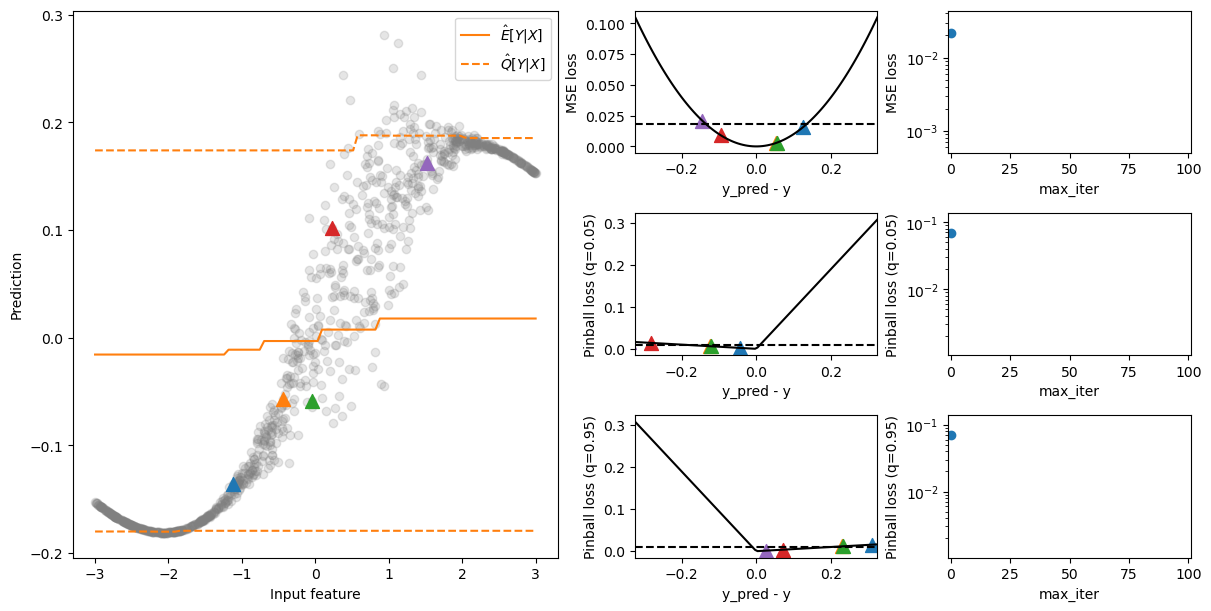

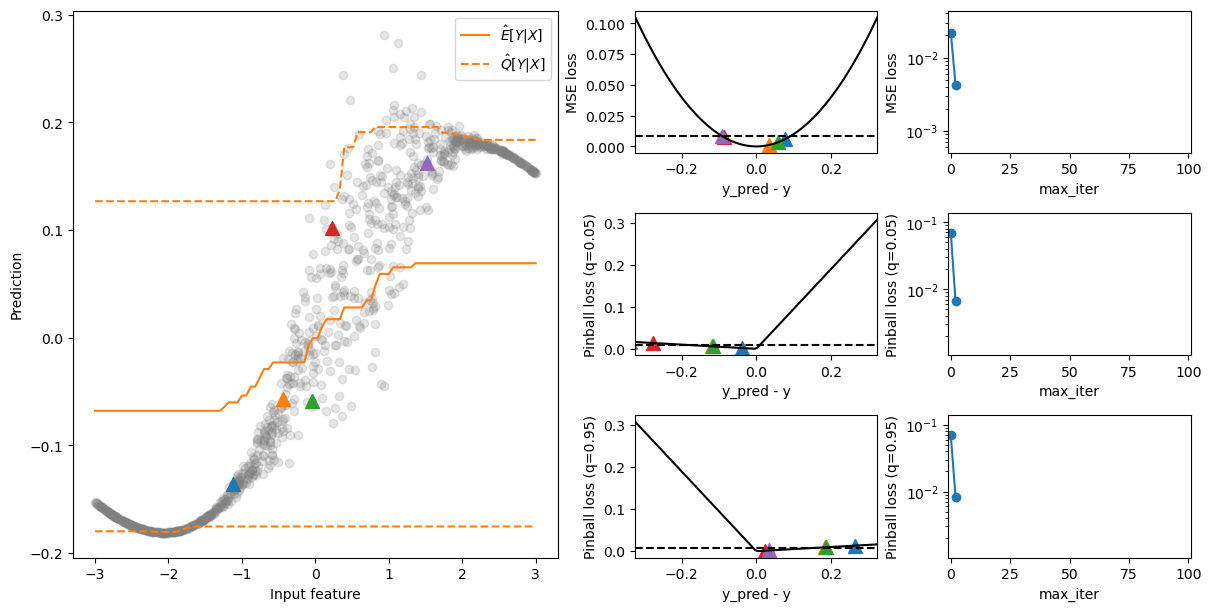

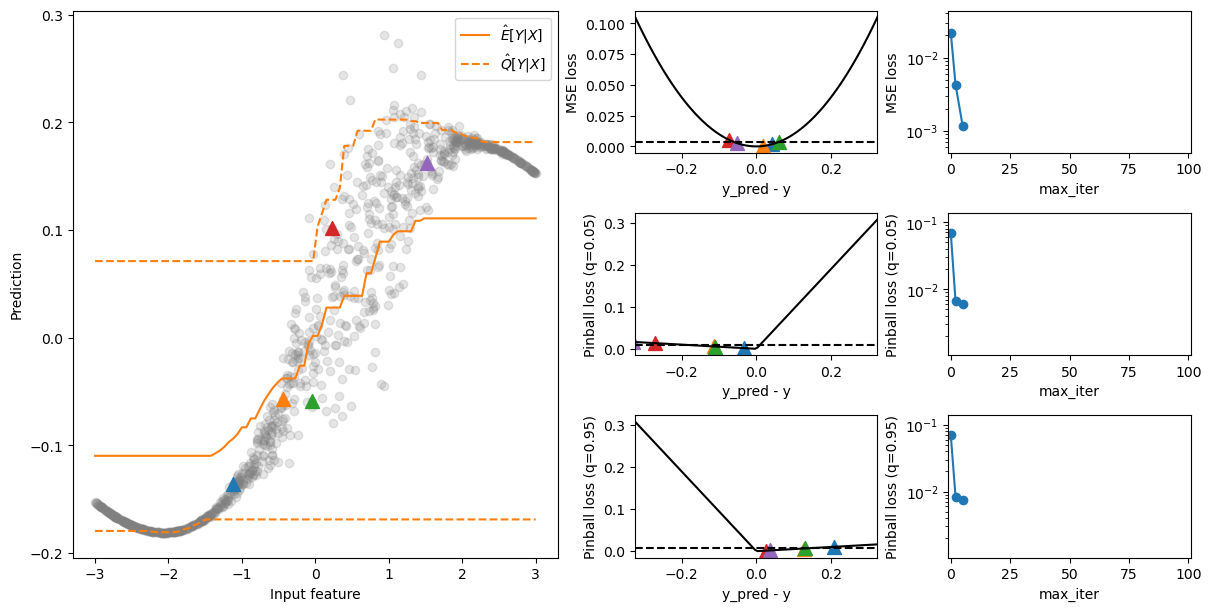

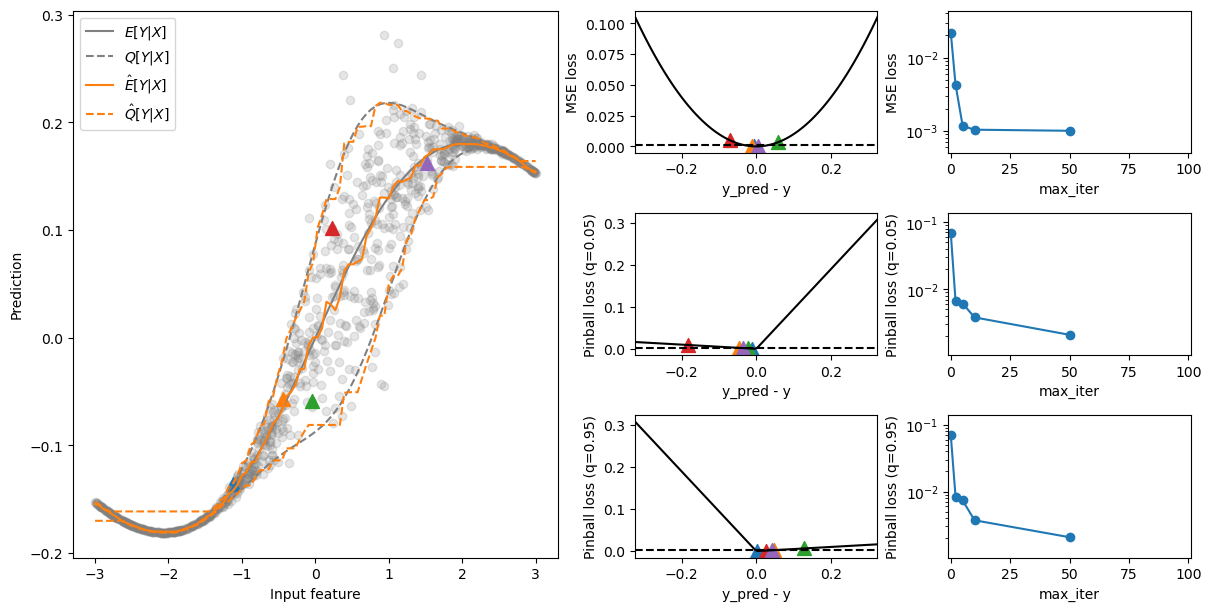

In [11]:
plot_curves(hgbt_reg_record, "HGBDT")

In [12]:
hgbt_qreg_below, hgbt_qreg_above = hgbt_reg_record[-1]["model_triplet"][1:3]

quantile_evaluator_test.evaluate(
    "HGBT QReg", hgbt_qreg_below.predict(X_test), hgbt_qreg_above.predict(X_test)
)
quantile_evaluator_test.to_frame()

,model,pinball loss at q=0.05,pinball loss at q=0.95,coverage,mean interval width
0,Polynomial QReg,0.0021,0.0318,0.9030,0.0642
1,HGBT QReg,0.0022,0.0352,0.9166,0.0711


In [13]:
from scipy.interpolate import interp1d
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.utils.validation import check_is_fitted
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.utils.validation import check_consistent_length
from sklearn.linear_model import LogisticRegression


class BinnedQuantileRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, estimator=None, n_bins=30, random_state=None):
        self.estimator = estimator
        self.n_bins = n_bins
        self.random_state = random_state

    def fit(self, X, y):
        # Lightweight input validation: most of the input validation will be
        # handled by the sub estimators.
        check_consistent_length(X, y)
        self.target_binner_ = KBinsDiscretizer(
            n_bins=self.n_bins,
            strategy="quantile",
            encode="ordinal",
            quantile_method="averaged_inverted_cdf",
        )

        y_binned = self.target_binner_.fit_transform(
            np.asarray(y).reshape(-1, 1)
        ).ravel()

        # Fit the multiclass classifier to predict the binned targets from the
        # training set.
        if self.estimator is None:
            estimator = LogisticRegression()
        else:
            estimator = clone(self.estimator)
        self.estimator_ = estimator.fit(X, y_binned)
        return self

    def predict_quantiles(self, X, quantiles):
        check_is_fitted(self, "estimator_")
        thresholds = self.target_binner_.bin_edges_[0]
        y_proba = self.estimator_.predict_proba(X)
        y_cdf = np.zeros(shape=(X.shape[0], thresholds.shape[0]))
        y_cdf[:, 1:] = np.cumsum(y_proba, axis=1)

        # Build the mapper for inverse CDF mapping, from cumulated
        # probabilities to continuous prediction.
        return np.asarray(
            [interp1d(y_cdf_i, thresholds)(quantiles) for y_cdf_i in y_cdf]
        )


base_classifier = make_pipeline(
    SplineTransformer(n_knots=10),
    LogisticRegression(C=1000, max_iter=1000),
)
bqr = BinnedQuantileRegressor(base_classifier, n_bins=1_000, random_state=0).fit(
    X_train, y_train
)

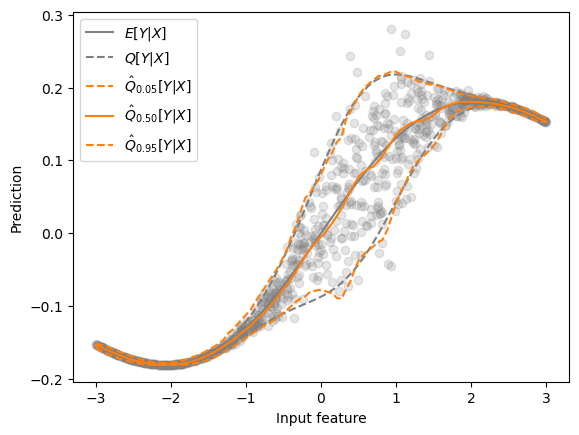

In [14]:
def plot_binned_qr(model, x, ax=None, color="C1"):
    x_grid = np.linspace(x.min(), x.max(), 100)
    X_grid = x_grid.reshape((x_grid.shape[0], 1))
    if ax is None:
        _, ax = plt.subplots(constrained_layout=True)

    quantile_levels = (0.05, 0.5, 0.95)
    q_pred = model.predict_quantiles(X_grid, quantile_levels)

    ax.plot(
        x_grid,
        q_pred[:, 0],
        label=r"$\hat{Q}_{0.05}[Y|X]$",
        color=color,
        linestyle="--",
    )
    ax.plot(x_grid, q_pred[:, 1], label=r"$\hat{Q}_{0.50}[Y|X]$", color=color)
    ax.plot(
        x_grid,
        q_pred[:, 2],
        label=r"$\hat{Q}_{0.95}[Y|X]$",
        color=color,
        linestyle="--",
    )
    ax.set(
        xlabel="Input feature",
        ylabel="Prediction",
    )
    ax.legend()


fig, ax = plt.subplots()
plot_data_generating_process(x_train, y_train, ax=ax)
plot_binned_qr(bqr, x, ax=ax)

In [15]:
binned_q_pred =  bqr.predict_quantiles(X_test, quantiles=[0.05, 0.95])
quantile_evaluator_test.evaluate(
    "Polynomial QReg via target binning", binned_q_pred[:, 0], binned_q_pred[:, 1]
)
quantile_evaluator_test.to_frame()

,model,pinball loss at q=0.05,pinball loss at q=0.95,coverage,mean interval width
0,Polynomial QReg,0.0021,0.0318,0.9030,0.0642
1,HGBT QReg,0.0022,0.0352,0.9166,0.0711
2,Polynomial QReg via target binning,0.0022,0.0336,0.9390,0.0697
